In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!kaggle datasets download -d arnavsmayan/netflix-userbase-dataset

Dataset URL: https://www.kaggle.com/datasets/arnavsmayan/netflix-userbase-dataset
License(s): Apache 2.0
  0% 0.00/25.1k [00:00<?, ?B/s]
100% 25.1k/25.1k [00:00<00:00, 31.4MB/s]


In [ ]:
import os
import zipfile

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
local_zip = '/content/netflix-userbase-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cure')
zip_ref.close()

In [ ]:
data = pd.read_csv('/content/cure/Netflix Userbase.csv')
data

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25-07-22,12-07-23,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,04-08-22,14-07-23,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,09-08-22,15-07-23,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,12-08-22,12-07-23,Canada,48,Female,Tablet,1 Month


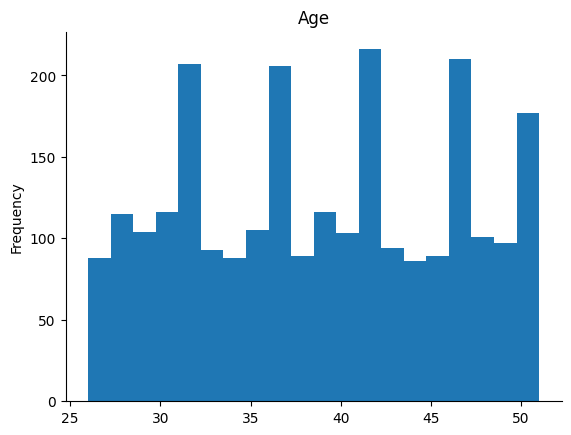

In [ ]:
# @title Age

from matplotlib import pyplot as plt
data['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as shc

In [ ]:
# Handling missing values in numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

In [ ]:
# One-hot encoding for categorical variables
categorical_columns = data.select_dtypes(include=[object]).columns.tolist()
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(data[categorical_columns]).toarray()
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_columns))

In [ ]:
# Combine the numeric and encoded categorical data
data_combined = pd.concat([data[numeric_columns], encoded_df], axis=1)

# Normalizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_combined)

In [ ]:
# PCA for dimensionality reduction
pca = PCA(n_components=10)  # Keeping 10 components for now
data_pca = pca.fit_transform(data_scaled)

# t-SNE for better visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data_pca)

In [ ]:

# CURE Clustering Algorithm using Agglomerative Clustering
def CURE(X, k):
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = model.fit_predict(X)
    return cluster_labels


In [ ]:

# Choosing the number of clusters using silhouette score with grid search
def choose_k(X, max_k=10):
    best_k = None
    best_silhouette_avg = -1
    best_db_index = float('inf')
    for k in range(2, max_k + 1):
        cluster_labels = CURE(X, k)
        silhouette_avg = silhouette_score(X, cluster_labels)
        db_index = davies_bouldin_score(X, cluster_labels)
        if silhouette_avg > best_silhouette_avg and db_index < best_db_index:
            best_silhouette_avg = silhouette_avg
            best_db_index = db_index
            best_k = k
    return best_k

In [ ]:
# Determining the optimal number of clusters
optimal_k = choose_k(data_pca)
print("Optimal number of clusters:", optimal_k)

Optimal number of clusters: 2


In [ ]:
# Clustering with optimal number of clusters
cluster_labels = CURE(data_pca, optimal_k)

# Adding cluster labels to the dataset
data['Cluster'] = cluster_labels

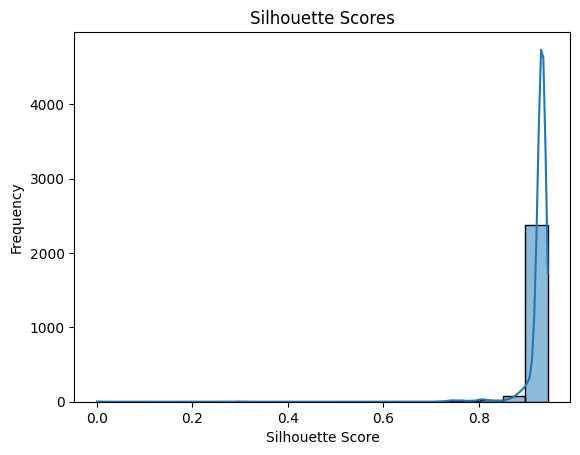

In [ ]:
# Visualizing the silhouette scores
silhouette_values = silhouette_samples(data_pca, cluster_labels)
sns.histplot(silhouette_values, bins=20, kde=True)
plt.title('Silhouette Scores')
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.show()

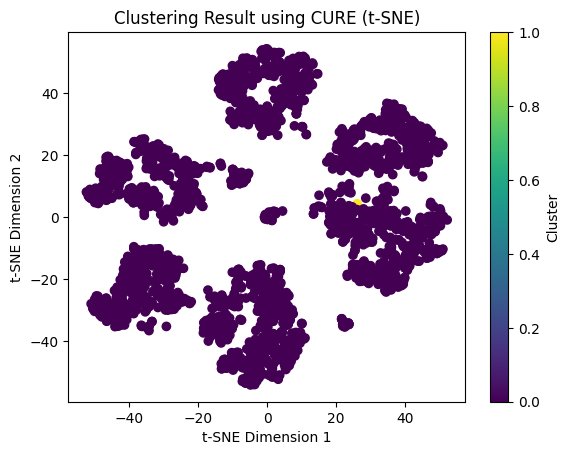

In [ ]:

# Visualizing the clusters using t-SNE
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clustering Result using CURE (t-SNE)')
plt.colorbar(label='Cluster')
plt.show()

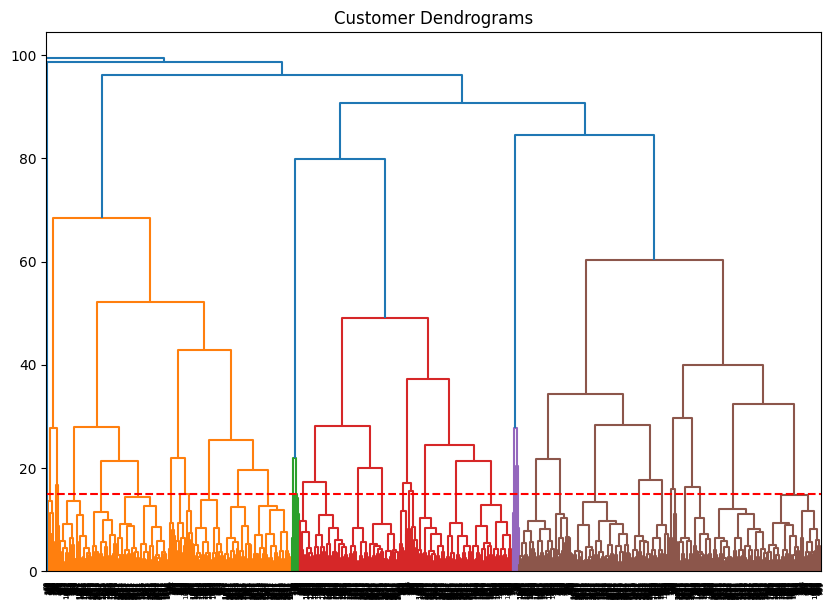

In [ ]:
# Dendrogram for hierarchical clustering visualization
plt.figure(figsize=(10, 7))
plt.title("Customer Dendrograms")
dend = shc.dendrogram(shc.linkage(data_pca, method='ward'))
plt.axhline(y=15, color='r', linestyle='--')
plt.show()

In [ ]:
# Additional evaluation metrics
db_score = davies_bouldin_score(data_pca, cluster_labels)
ch_score = calinski_harabasz_score(data_pca, cluster_labels)
print(f"Davies-Bouldin Index: {db_score}")
print(f"Calinski-Harabasz Index: {ch_score}")

# Displaying clustered dataset
print(data)

Davies-Bouldin Index: 0.05177342030313143
Calinski-Harabasz Index: 268.4597929208974
      User ID Subscription Type  Monthly Revenue Join Date Last Payment Date  \
0           1             Basic               10  15-01-22          10-06-23   
1           2           Premium               15  05-09-21          22-06-23   
2           3          Standard               12  28-02-23          27-06-23   
3           4          Standard               12  10-07-22          26-06-23   
4           5             Basic               10  01-05-23          28-06-23   
...       ...               ...              ...       ...               ...   
2495     2496           Premium               14  25-07-22          12-07-23   
2496     2497             Basic               15  04-08-22          14-07-23   
2497     2498          Standard               12  09-08-22          15-07-23   
2498     2499          Standard               13  12-08-22          12-07-23   
2499     2500             Basic    

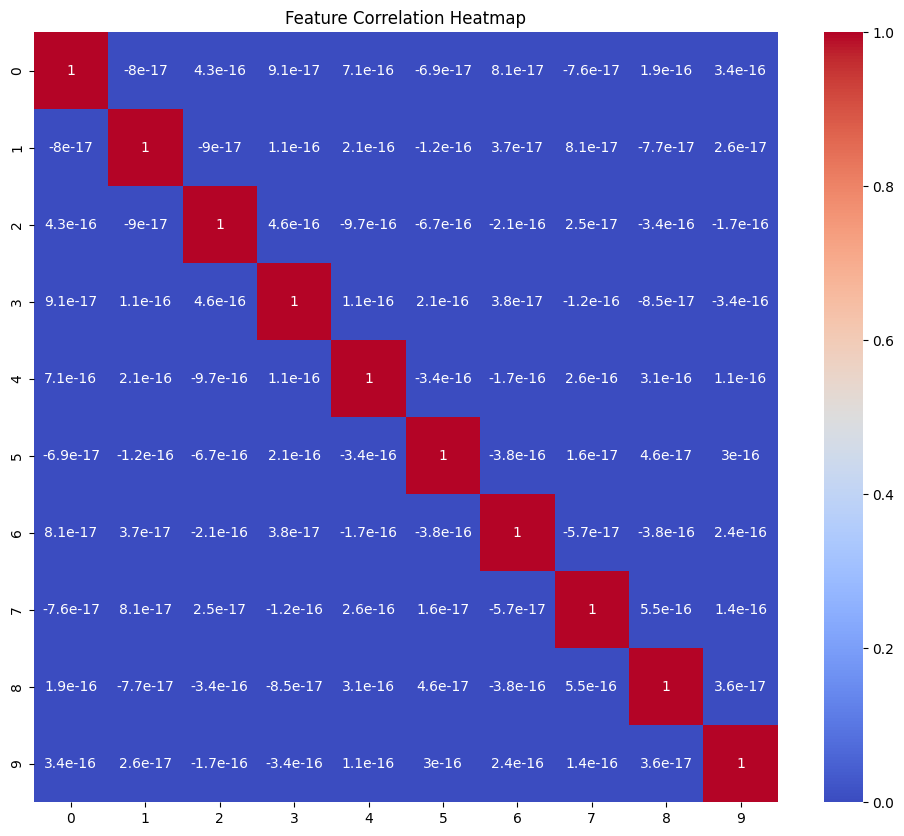

In [ ]:
# Heatmap of feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(data_pca).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

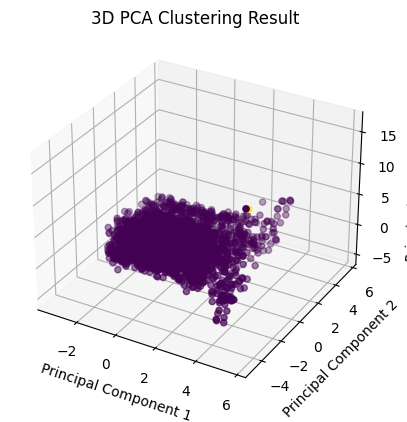

In [ ]:
# 3D PCA Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=cluster_labels, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA Clustering Result')
plt.show()